<a href="https://colab.research.google.com/github/mmilannaik/bostonhousepricing/blob/main/W29S2_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240827%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240827T094634Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D76246409e11c1bbb63013430fa3e019436f53be18fa060efa525f0ab8aeac25f652f833f11cea8ee2d77048187c97f09be07a44138ab14681d8084e8f52373963dfb87dc6e03f655a6a48625ee9e03375a607d2048199cbc2eb39f1337ed02babf778cd101916592a4384098a5914f88720a6b7288a3533ced89fee6cb210dfe29ffe7804b6096c3f31c3067138a3989ab1a513b5ae5ec0e0ca307432116e18b6ca49c2c0ad3b5b37588ca2bf25307bae2a95937fda2459d7272c6eb1703de8d3426c891daba7ffddb4b844034e26cbd79b8ae2c0efdbdc3f8cb9aca545d6d9d81ad9937a008e6bfac0839703b7825381d093a447b97f955985fdc43e307231f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [3]:

import numpy as np
import pandas as pd

# **Import Libraries**

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

# **Import Data**

In [5]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [6]:
df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [7]:
df.shape

(42000, 785)

In [8]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.sample()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
26134,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
import matplotlib.pyplot as plt

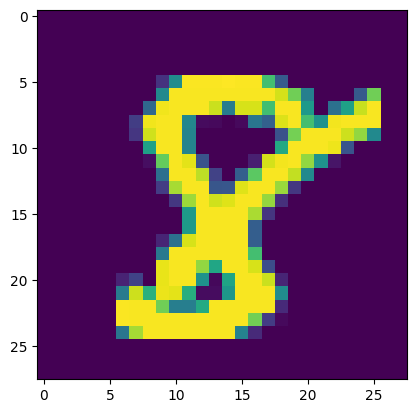

In [11]:
plt.imshow(df.iloc[26134,1:].values.reshape(28,28))

In [12]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [14]:
X_train.shape

(33600, 784)

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [16]:
import time
start = time.time()
y_pred = knn.predict(X_test)
print(time.time()-start)

32.371851444244385


In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9648809523809524

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [19]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **EDA**

In [ ]:
df.shape

In [ ]:
df_test.shape

In [ ]:
df.head()

In [ ]:
def reshape_row(row):
    return row[:].reshape(28, 28)


train_reshaped_matrices = np.array([reshape_row(row) for row in df.values])
test_reshaped_matrices  = np.array([reshape_row(row) for row in df_test.values])

In [ ]:
print(train_reshaped_matrices.shape)
print(test_reshaped_matrices.shape)

In [ ]:
train_reshaped_matrices = np.expand_dims(train_reshaped_matrices,axis = -1)
test_reshaped_matrices = np.expand_dims(test_reshaped_matrices,axis = -1)

In [ ]:
print(train_reshaped_matrices.shape)
print(test_reshaped_matrices.shape)

In [ ]:
# Normalize
train_reshaped_matrices = train_reshaped_matrices.astype('float32') / 255.0
test_reshaped_matrices = test_reshaped_matrices.astype('float32') / 255.0

# **Images**

In [ ]:
def plot_images_randomly():
    plt.figure(figsize = (12,4))
    for i in range(10):
        plt.subplot(2,5,i + 1)
        random_idx = np.random.randint(low = 0,high=df.shape[0])
        plt.title(labels[random_idx][0],fontsize = 14)
        plt.imshow(train_reshaped_matrices[random_idx])
        plt.axis('off')
    plt.show()

In [ ]:
plot_images_randomly()

# **Split Data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_reshaped_matrices,labels,test_size = 0.2,random_state = 41)

In [ ]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# **Model Implementation**
For this task I've decided to use LeNet architecrture

In [ ]:
model = tf.keras.Sequential([
        Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPool2D(strides=2),
        Dropout(0.25),

        Conv2D(filters=64, kernel_size=(5,5), padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPool2D(strides=2),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(84, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# **Define Callbacks**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
callbacks = [early_stopping, reduce_lr]

# **Training the model**

In [ ]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=callbacks)

# **Make Predictons**

In [ ]:
predictions = model.predict(test_reshaped_matrices).argmax(axis=1)
predictions

# **Analyze the Predictions**

In [ ]:
def plot_predicted():
    """
    Randomly Prints Images with their Predicted Labels
    """
    plt.figure(figsize=(12, 10))
    for i in range(20):
        random_idx = np.random.randint(low=0, high=test_reshaped_matrices.shape[0])

        plt.subplot(5, 4, i + 1)
        plt.imshow(test_reshaped_matrices[random_idx])
        plt.axis('off')
        plt.title(predictions[random_idx])

    plt.tight_layout()
    plt.show()

plot_predicted()

In [ ]:
conf_matrix = confusion_matrix(y_test.argmax(axis=1),model.predict(X_test).argmax(axis=1))

ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

In [ ]:
epochs = history.epoch

plt.figure(figsize = (12,5))
for i,metric in enumerate(list(history.history.keys())[:-1]):
    plt.subplot(1,2,i%2+1)
    plt.plot(epochs,history.history[metric],label = metric)
plt.legend()
plt.show()

# **Submission File**

In [ ]:
pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')

In [ ]:
submission = pd.DataFrame({'ImageId': range(1,len(test_reshaped_matrices)+1), 'Label': predictions})
submission.to_csv('submission.csv',index = False)

# **Conclusion**
We've implemented model with LeNet architecture and reach **99.4%** accuracy! Its simplicity makes it ideal for small-scale image classification tasks such as Handwritten Digit Recongnition.